## <center> __Assignment: Convolutional Neural Networks (CNN) for Image Processing__ </center>

### __Objectives :__
- 1.	Understand the architecture and working of Convolutional Neural Networks (CNNs).
- 2.	Apply CNNs to perform image classification using a real-world dataset.
- 3.	Implement image preprocessing techniques (e.g., resizing, normalization).
- 4.	Visualize and interpret the model’s performance.


### __Dataset:__
- Intel Image Classification (Real-World Scenes – Intermediate/Advanced)

### __1. Data Loading and Preprocessing__

### __- Data Loading__

In [1]:
!mkdir -p ~/.kaggle

!mv kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors


In [2]:
!unzip -d /content/intel-image-classification /content/intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: /content/intel-image-classification/seg_train/seg_train/mountain/7506.jpg  
  inflating: /content/intel-image-classification/seg_train/seg_train/mountain/7537.jpg  
  inflating: /content/intel-image-classification/seg_train/seg_train/mountain/7539.jpg  
  inflating: /content/intel-image-classification/seg_train/seg_train/mountain/7551.jpg  
  inflating: /content/intel-image-classification/seg_train/seg_train/mountain/7560.jpg  
  inflating: /content/intel-image-classification/seg_train/seg_train/mountain/7565.jpg  
  inflating: /content/intel-image-classification/seg_train/seg_train/mountain/7578.jpg  
  inflating: /content/intel-image-classification/seg_train/seg_train/mountain/7581.jpg  
  inflating: /content/intel-image-classification/seg_train/seg_train/mountain/7586.jpg  
  inflating: /content/intel-image-classification/seg_train/seg_train/mountain/7647.jpg  
  inflating: /content/intel-image-classification/seg_train/

### __Importing Libraries :__

In [3]:
!pip install scikit-learn

In [115]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os, shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

### __Data Splitting__

In [146]:
# Training dataset
train_dataset = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
training_set = train_dataset.flow_from_directory('/content/intel-image-classification/seg_train/seg_train',
                                                 target_size=(150, 150),
                                                 batch_size= 32,
                                                 class_mode='categorical')

Found 14034 images belonging to 6 classes.


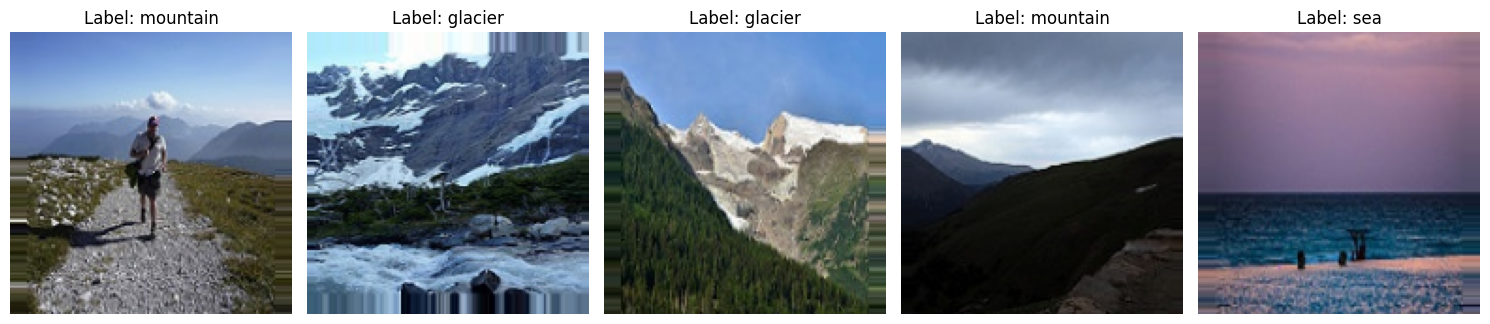

In [147]:
# Get one batch of images and one-hot encoded labels
images, labels = next(training_set)

# Get class names in the correct order
class_names = list(training_set.class_indices.keys())

# Convert one-hot encoded labels to class indices
if len(labels.shape) > 1:
    labels = np.argmax(labels, axis=1)

# Display first 5 images with their corresponding labels
plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {class_names[labels[i]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [148]:
test_dataset = ImageDataGenerator(rescale = 1./255)
test_set = test_dataset.flow_from_directory('/content/intel-image-classification/seg_test/seg_test',
                                            target_size = (150, 150),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            shuffle=False
                                            )

Found 3000 images belonging to 6 classes.


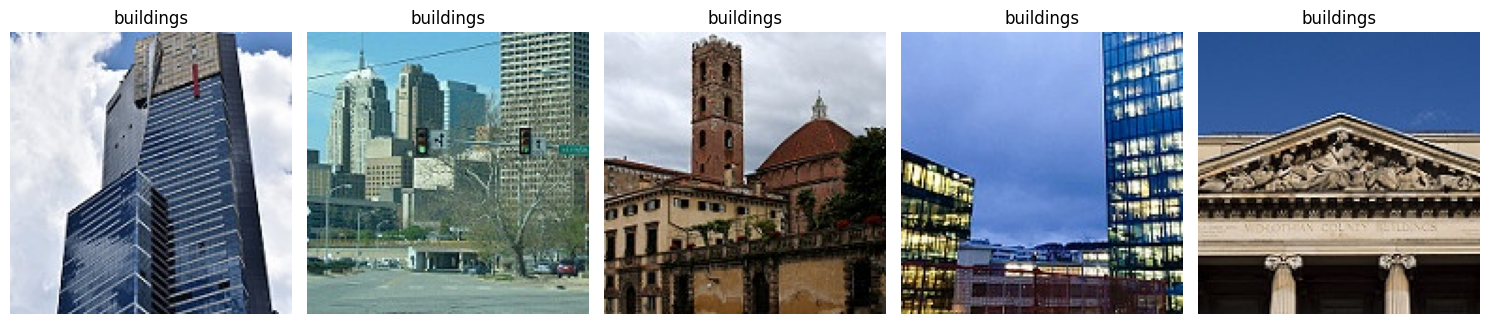

In [149]:
# Display sample images and labels from test set
images, labels = next(test_set)
class_names = list(test_set.class_indices.keys())
labels = np.argmax(labels, axis=1)

plt.figure(figsize=(15, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[labels[i]])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [150]:
pred_dataset = ImageDataGenerator(rescale = 1./255)
pred_set = pred_dataset.flow_from_directory('/content/intel-image-classification/seg_pred',
                                          target_size = (128, 128),
                                          batch_size = 32,
                                          class_mode = 'categorical')

Found 7301 images belonging to 1 classes.


### __2.	Model Building__

In [151]:
#Model Building
cnn=tf.keras.models.Sequential() #initializing the model

In [152]:
#Add convolutional layer 1
cnn.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu',input_shape=[150,150,3]))
#Add pooling layer 1
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))
#Add dropout layer in layer 1
cnn.add(tf.keras.layers.Dropout(0.25))


#Add convolutional layer 2
cnn.add(tf.keras.layers.Conv2D(filters=256,kernel_size=3,activation='relu'))
#Add pooling layer 2
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))
#Add Dropout layer in layer 2
cnn.add(tf.keras.layers.Dropout(0.25))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [153]:
#Flattening the layer
cnn.add(tf.keras.layers.Flatten())

#Adding fully connected layer 1
cnn.add(tf.keras.layers.Dense(units=128,activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.25))

#Adding fully connected layer 2
cnn.add(tf.keras.layers.Dense(units=64,activation='relu'))
cnn.add(tf.keras.layers.Dropout(0.25))

#output
cnn.add(tf.keras.layers.Dense(units=6,activation='softmax'))


In [154]:
cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 148, 148, 128)       │           3,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 74, 74, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 74, 74, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 72, 72, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 36, 36, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 36, 36, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 331776)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │      42,467,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 42,774,854 (163.17 MB)

 Trainable params: 42,774,854 (163.17 MB)

 Non-trainable params: 0 (0.00 B)

In [157]:
#compling the model
cnn.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


### __3.	Model Training__

In [158]:
# Callbacks for early stopping and reducing learning rate
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

In [159]:
#Training the model
model_train = cnn.fit(training_set,validation_data=test_set,epochs=20,callbacks=[early_stop, reduce_lr])


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 117s 256ms/step - accuracy: 0.4193 - loss: 1.6588 - val_accuracy: 0.6687 - val_loss: 0.8525 - learning_rate: 0.0010
Epoch 2/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 91s 206ms/step - accuracy: 0.6379 - loss: 0.9565 - val_accuracy: 0.6947 - val_loss: 0.8209 - learning_rate: 0.0010
Epoch 3/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 90s 204ms/step - accuracy: 0.6875 - loss: 0.8630 - val_accuracy: 0.7583 - val_loss: 0.6712 - learning_rate: 0.0010
Epoch 4/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 90s 204ms/step - accuracy: 0.7207 - loss: 0.7866 - val_accuracy: 0.7473 - val_loss: 0.7235 - learning_rate: 0.0010
Epoch 5/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 89s 204ms/step - accuracy: 0.7526 - loss: 0.6866 - val_accuracy: 0.7540 - val_loss: 0.6440 - learning_rate: 0.0010
Epoch 6/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 89s 202ms/step - accuracy: 0.7631 - loss: 0.6646 - val_accuracy: 0.7870 - val_loss: 0.5913 - learning_rate: 0.0010
Epoch 7/20
439/439 ━━━━━━━━━━━━━━━━━━━━ 142s 202ms/step - accuracy: 0

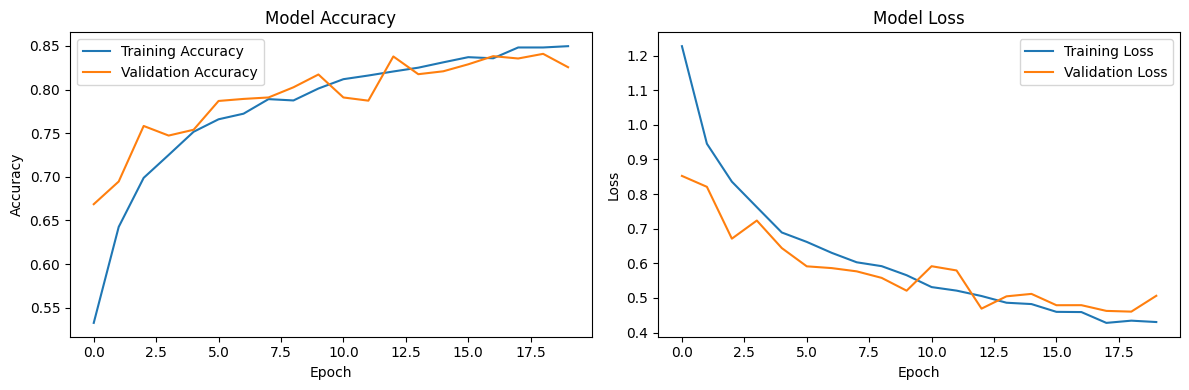

In [160]:
# Plotting the accuracy graph
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(model_train.history['accuracy'], label='Training Accuracy')
plt.plot(model_train.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

#Plotting the Loss graphs
plt.subplot(1, 2, 2)
plt.plot(model_train.history['loss'], label='Training Loss')
plt.plot(model_train.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### __4.	Model Evaluation__

In [161]:
test_loss, test_accuracy = cnn.evaluate(test_set)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.8353 - loss: 0.4556
Test Loss: 0.4604
Test Accuracy: 0.8410


In [162]:
#Evaluating model on test set
y_pred = cnn.predict(test_set)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_set.classes

print("Predicted Classes:", y_pred_classes)
print("True Classes:", y_true)

94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step
Predicted Classes: [0 5 0 ... 3 5 5]
True Classes: [0 0 0 ... 5 5 5]


In [163]:
#calculating the accuracy, precision, recall and f1score
accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")
precision = precision_score(y_true, y_pred_classes, average='weighted')
print(f"Precision: {precision:.4f}")
recall = recall_score(y_true, y_pred_classes, average='weighted')
print(f"Recall: {recall:.4f}")
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8410
Precision: 0.8404
Recall: 0.8410
F1 Score: 0.8401


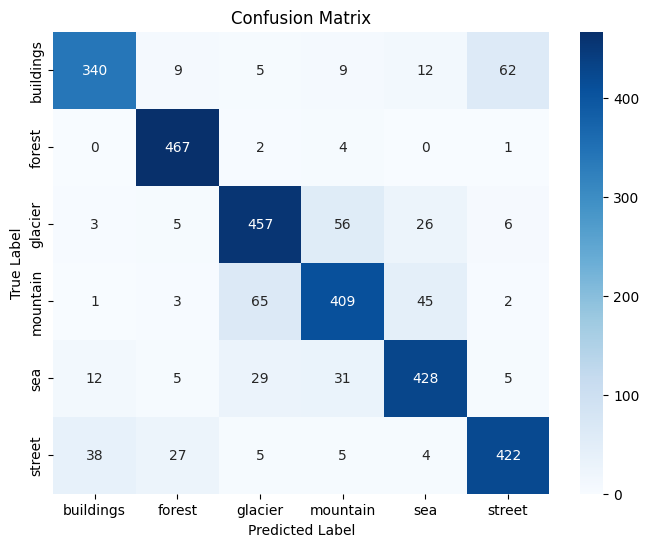

In [164]:
#confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

### __🔹 Task 3: Visualization and Interpretation__

94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step


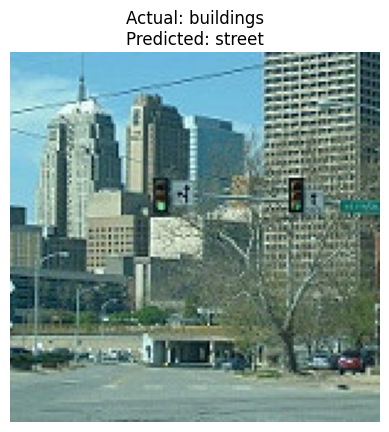

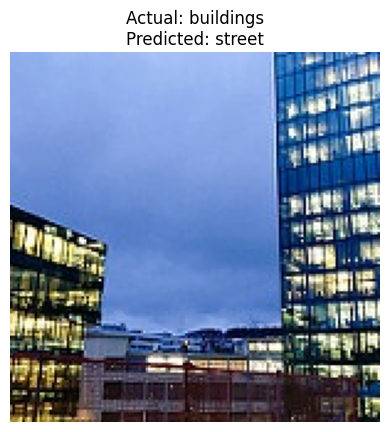

In [165]:
#Reseting the generator
test_set.reset()
# getting predictions on the entire test set
y_pred_prob = cnn.predict(test_set, steps=len(test_set))
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_set.classes

misclassified_indices = np.where(y_pred != y_true)[0]

#Adding all image into one array
X_test = []
for i in range(len(test_set)):
    batch_X, _ = test_set[i]
    X_test.append(batch_X)
X_test = np.concatenate(X_test)

#misclassified images with their actual and predicted labels
num_images_to_display = 2
for idx in misclassified_indices[:num_images_to_display]:
    image = X_test[idx]
    actual_label = class_names[y_true[idx]]
    predicted_label = class_names[y_pred[idx]]

    plt.imshow(image)
    plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
    plt.axis('off')
    plt.show()


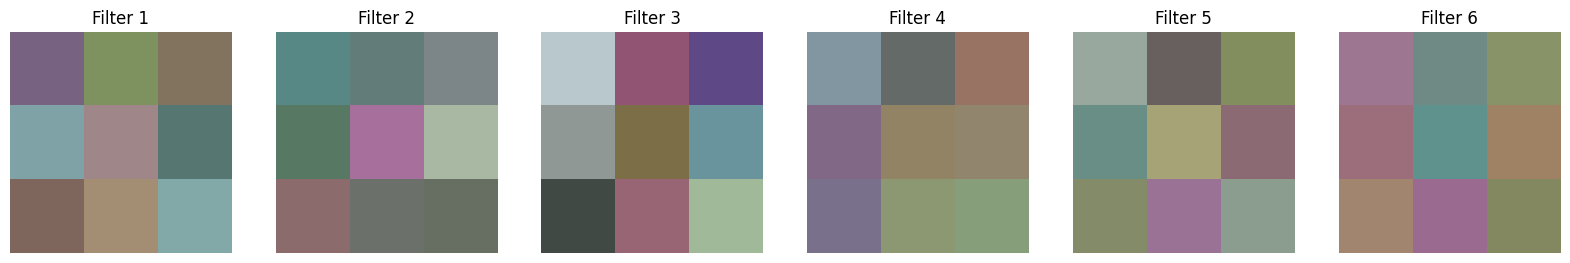

In [166]:
#First CNN layer
conv_layer = cnn.layers[0]

#weights of the layer
filters, biases = conv_layer.get_weights()

#Normalize filter value
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

#No of filter to display
n_filters = 6
fig, axes = plt.subplots(1, n_filters, figsize=(20, 8))
for i in range(n_filters):
    f = filters[:, :, :, i]
    axes[i].imshow(f, interpolation='nearest')
    axes[i].set_title(f'Filter {i+1}')
    axes[i].axis('off')
plt.show()


This project details the process of creating a Convolutional Neural Network to classify images of the Intel dataset. The data has been preprocessed with rescaling and augmentation to develop a sequential CNN having convolutional, pooling, dropout, and dense layers. The training is carried out using early stopping and reduction in learning rate to get competitive results with high accuracy, precision, recall, and F1 scores. But it misclassifies some scene types because of the confusion matrix. In conclusion, to boost the network, more data augmentation techniques, and further hyperparameter adjustments with deep or transfer learning architectures should be used to better capture complex features from the image.